## <span style="color: white; background-color:rgb(0, 156, 217); padding:5px 20px; border-radius: 20px; font-weight:bold; font-size: 30pt">Brind TC data 🌀</span>

In [1]:
#%%
import os
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import plotly.figure_factory as ff
import matplotlib.collections as mcoll
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from geopy.distance import geodesic
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.ticker as ticker
import tcmarkers

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage.measure import regionprops
from sklearn.decomposition import PCA

import scipy.ndimage as ndimage
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from scipy.ndimage import binary_dilation, minimum_filter, maximum_filter, label
from scipy import integrate
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups

pangu_dir = r'/data03/Pangu_TC_ENS'

pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)


#%%
#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(100,160,5,45)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


ssv_dict = {}


#태풍 지정
# storm_name, storm_year, key_time_list  = 'HINNAMNOR', 2022, ['2022/08/27/00UTC']
# storm_name, storm_year, key_time_list  = 'NORU', 2017, ['2017/07/30/00UTC']
storm_name, storm_year, key_time_list  = 'DEBBY', 2012, ['2012/06/23/00UTC']                                                                               


if storm_name == 'DEBBY':
    lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(250,310,5,45)  
    lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
if storm_name == 'HINNAMNOR':
    perturation_scale = 0.05
else:
    perturation_scale = 0.1

#예측 시간 지정, 초기 시간 지정, 앙상블 수
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,4000)
ens_num = len(ens_list)  # 앙상블 수
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로


if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''
        
#! 태풍 경로 정보 새로 생성하기
if new_ssv == 'y':
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가


        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])

        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력
        if any(lon < 0 for lon in storm_lon):
            storm_lon = [lon + 360 if lon < 0 else lon for lon in storm_lon]
        storm_lon = np.array(storm_lon)

        min_position = {}  # 태풍 중심 정보 dictionary



        # for ens in range(ens_num):
        for ens in ens_list:
            print(f'{ens}번째 앙상블 예측')
            min_position[ens] = {}
            output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
            # output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{ens}'
            
            
            
            for predict_interval in predict_interval_list:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
              
                #mask_size는 다음 태풍 찾을 때 그 위경도 안이 아니면 안 찾음S
                #처음 시작할 때는 5도 이내에만 들어오면 되고
                #mslp_z_dis는 250이 기본인데 이는 mslp 지역 최솟값과 z지역 최댓값이 250km 이내여야 pass
                #mslp_2hpa는 주변 8방위로 2hPa이 감소하는지 보는건데 일단은 'n'으로 걸어둠
                #아래에서는 mask_size말고는 아무런 제약을 안 걸었음
                min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                        wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                        min_position[ens], mask_size = 2.5, init_size=5, local_min_size = 5, mslp_z_dis = 250, wind_thres=0)

            
            for predict_interval in predict_interval_list[::-1]:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
                
                if retro_opt != '_td':
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 1000, wind_thres=0)
                else:
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 250, wind_thres=0)
                    
                
                min_position[ens] = {k: min_position[ens][k] for k in sorted(min_position[ens])}
                
        ssv_dict[ssv_key] = min_position

    with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'wb') as f:
    # with open(rf'{pangu_dir}/output_data/{first_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'wb') as f:
        pickle.dump(ssv_dict, f)

else:
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가
        
        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])
        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력
        if any(lon < 0 for lon in storm_lon):
            storm_lon = [lon + 360 if lon < 0 else lon for lon in storm_lon]
        storm_lon = np.array(storm_lon)
        
        with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
        # with open(rf'{pangu_dir}/output_data/{first_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
            ssv_dict = pickle.load(f)


def normalize_lon(lon):
    """경도를 항상 -180~180 사이로 변환"""
    lon = np.array(lon)
    lon = ((lon + 180) % 360) - 180
    return lon

## Draw TC data 🌀

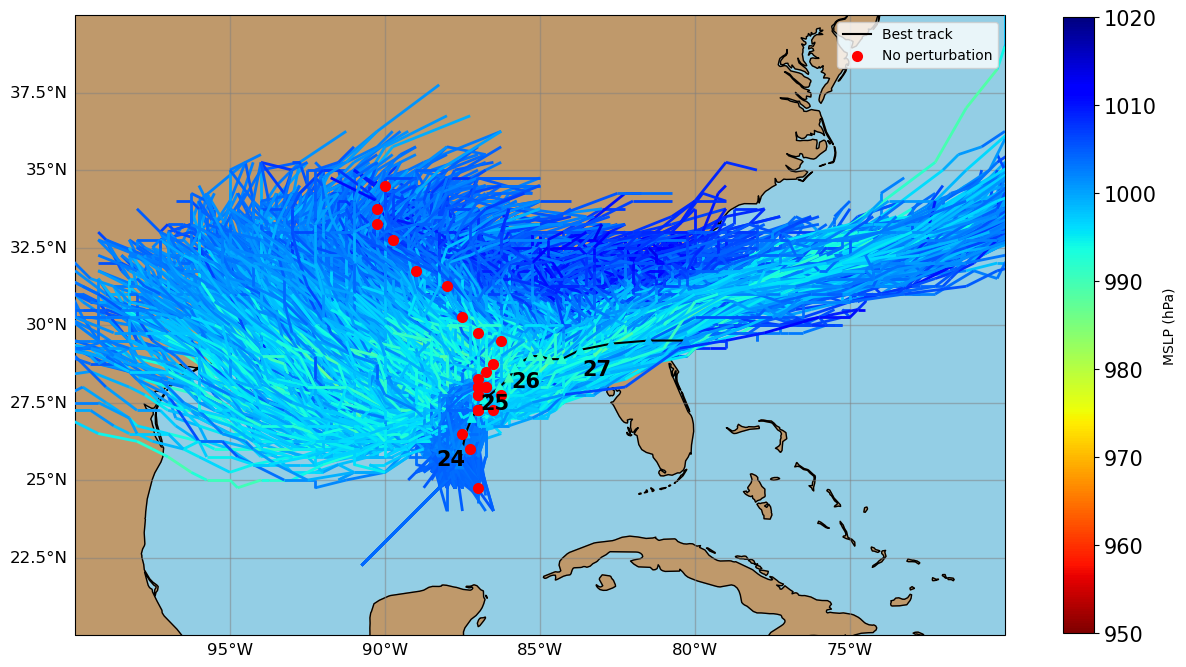

In [4]:


#! 태풍 경로 그리기
for key_time ,min_position in ssv_dict.items():
    fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
    key_str = key_time.strftime("%m.%d.%HUTC")
    # ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval_list[-1]}h)', fontsize=20, loc = 'left')
    # ax.set_title(f'ENS{surface_str}{upper_str}{perturation_scale} Track\n{storm_name}', fontsize=20, loc = 'right')
    # ax.set_title(f'{storm_name}', fontsize=20, loc = 'right')
    ax.set_extent([260,290,20,40], crs=proj)
    setup_map(ax)

    ax.plot(storm_lon, storm_lat, color='black', linestyle='-', marker='', label = 'Best track', transform=ax.projection, zorder=10)
    model_pred_sc = ax.scatter(storm_lon-360, storm_lat, c=storm_mslp, cmap='jet_r', marker='^',norm=norm_p, transform=ax.projection, zorder=10)
    cbar = plt.colorbar(model_pred_sc, ax=ax, orientation='vertical', label='MSLP (hPa)', shrink=0.8)
    cbar.ax.tick_params(labelsize=15)

    
    for i in range(len(storm_time)):
        new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
        if new_time.endswith('00UTC'):
            dx, dy = 5, -0.5  # 시간 나타낼 위치 조정
            new_lon, new_lat = storm_lon[i] + dx, storm_lat[i] + dy
            
            # annotate를 사용하여 텍스트와 함께 선(화살표)을 그림
            ax.text(storm_lon[i]-360, new_lat, new_time[8:-6]
                    , horizontalalignment='right', verticalalignment='top', fontsize=15, zorder = 20, fontweight = 'bold')



    for ens in range(ens_num):  
    # for ens in ens_list:  


        lons = [pos['lon']-360 for _,pos in min_position[ens].items()]
        lats = [pos['lat'] for _,pos in min_position[ens].items()]
        min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
        pred_times = [pos for pos,_ in min_position[ens].items()]
        # print(ens)
        lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)

        #? 시간 표시 00UTC만 표시, 없앨듯

        if ens == 0:
            lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)
            ax.scatter(lons, lats, c='red', linewidth=2, alpha=1, zorder=10, label = 'No perturbation')

            # for i in range(len(pred_times)):
            #     if pred_times[i].hour == 0:
            #         ax.text(lons[i],lats[i], str(pred_times[i].day)
            #             , horizontalalignment='center', verticalalignment='bottom', fontsize=10, zorder = 6)

        
    ax.legend(loc='upper right')


    lons_all = np.concatenate([np.array([pos['lon'] for _, pos in min_position[ens].items()]) for ens in range(ens_num)])
    lats_all = np.concatenate([np.array([pos['lat'] for _, pos in min_position[ens].items()]) for ens in range(ens_num)])


    xy = np.vstack([lons_all, lats_all])
    kde = gaussian_kde(xy)
    positions = np.vstack([lon_grid.ravel(), lat_grid.ravel()])
    f = np.reshape(kde(positions).T, lon_grid.shape)


    levels = np.linspace(0.0005, 0.015, 100)
    # cf = ax.contourf(lon_grid, lat_grid, f, levels=levels, transform=proj, cmap='jet')
    plt.show()
    fig.savefig(f'/home1/jek/Pangu-Weather/plot/{storm_name}_Ensemble_track_{key_str}.png',bbox_inches='tight')
    

## draw each ensemble data

11번째 앙상블 예측


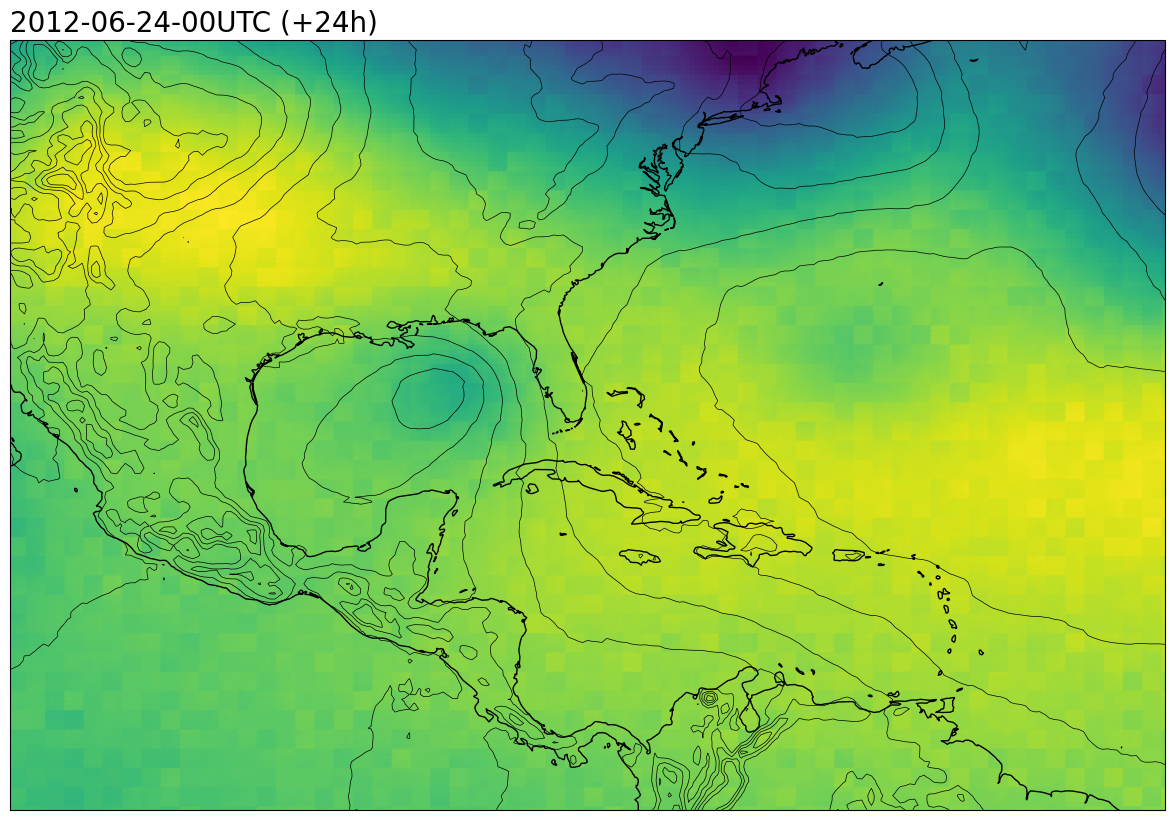

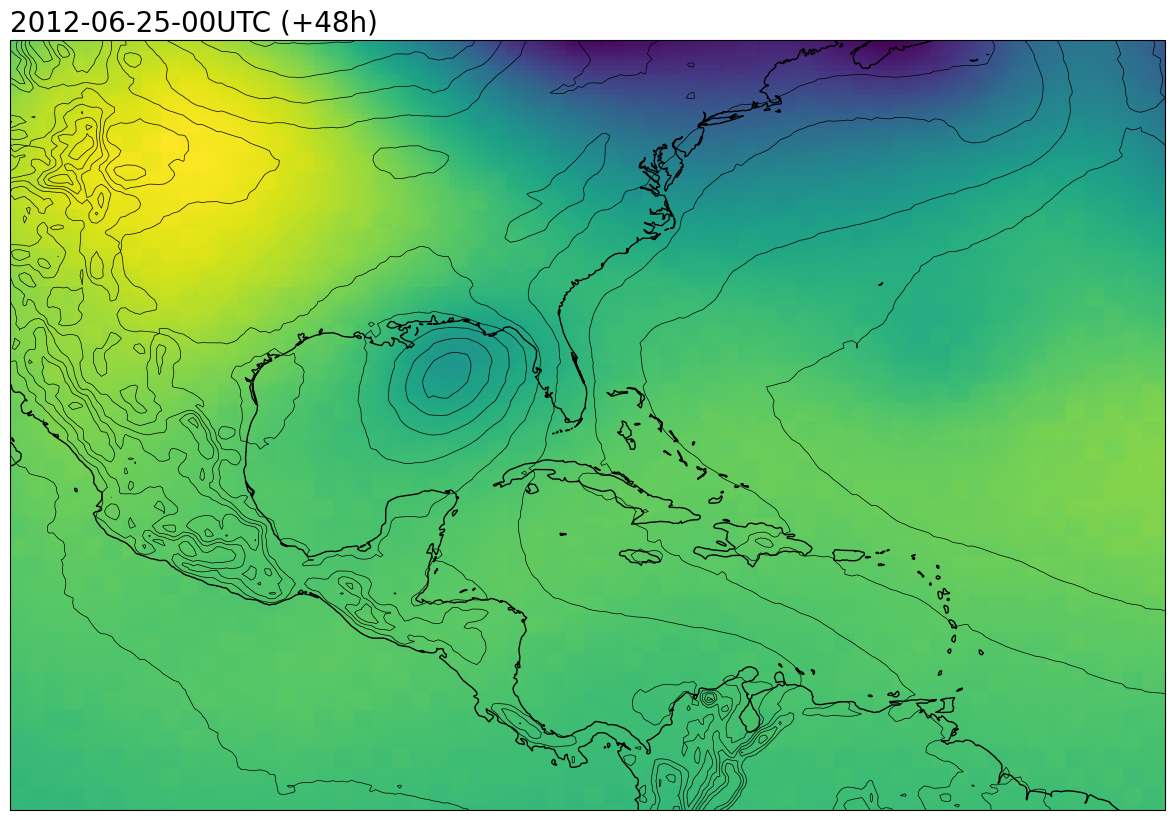

In [10]:
for ens in [11]:
    print(f'{ens}번째 앙상블 예측')
    # min_position[ens] = {}
    output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
    # output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{ens}'
    
    
    
    # for predict_interval in predict_interval_list:
    for predict_interval in range(24, 49, 24):
        predict_time = first_time + timedelta(hours=int(predict_interval))
        predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
        met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
        u_500 = met.met_data('u', level = 500) 
        v_500 = met.met_data('v', level = 500)
        fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
        ax.set_title(f'{predict_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval}h)', fontsize=20, loc = 'left')
        # ax.streamplot(lon_grid, lat_grid, u_500, v_500, color='black', linewidth=1, density=10, transform=proj)
        # ax.set_extent([120,155,20,45], crs=proj)
        z_500 = met.met_data('z', level = 500)
        mslp = met.met_data('MSLP')
        ax.scatter(lon_grid, lat_grid, c=z_500, s=20, transform=proj)
        ax.contour(lon_grid, lat_grid, mslp, levels=np.arange(950, 1020, 2), colors='black', linewidths=0.5, transform=proj)
        # setup_map(ax)
        ax.coastlines()
        plt.show() 

    break

## Scatter each time step TC locatons

Total number of ensemble members: 84


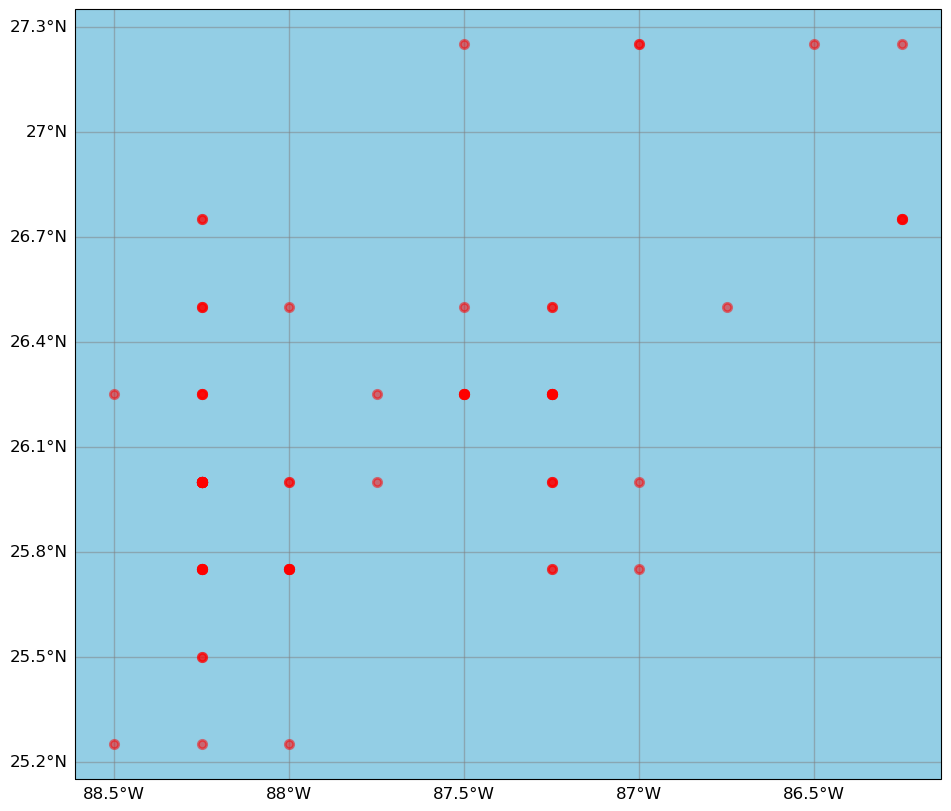

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
key_str = key_time.strftime("%m.%d.%HUTC")
# ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval_list[-1]}h)', fontsize=20, loc = 'left')
# ax.set_title(f'ENS{surface_str}{upper_str}{perturation_scale} Track\n{storm_name}', fontsize=20, loc = 'right')
# ax.set_title(f'{storm_name}', fontsize=20, loc = 'right')
# ax.set_extent([120,155,20,45], crs=proj)
setup_map(ax)
obs_time = datetime(2012, 6, 24, 0, 0)
total_num = 0

for ens in ens_list:  
    if obs_time not in min_position[ens]:
        continue


    # lons = [pos['lon'] for _,pos in min_position[ens].items()][-1]
    # lats = [pos['lat'] for _,pos in min_position[ens].items()][-1]
    # min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
    # pred_times = [pos for pos,_ in min_position[ens].items()]
    # print(ens)
    # lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)

    ax.scatter(min_position[ens][obs_time]['lon'], min_position[ens][obs_time]['lat'], c='red', linewidth=2, alpha=0.5, zorder=10, label = 'No perturbation')
    #? 시간 표시 00UTC만 표시, 없앨듯
    total_num += 1
print(f'Total number of ensemble members: {total_num}')

In [2]:
if storm_name == 'HINNAMNOR':
    key_time = datetime(2022,8,27,0)             #처음 시점 지정
    start_time = datetime(2022,8,28,0)           #분석 시작 시점
    target_time = datetime(2022,9,1,0)           #위치 projection을 구하고자 하는 시간
elif storm_name == 'NORU':
    key_time = datetime(2017,7,30,0)              #처음 시점 지정
    start_time = datetime(2017,7,30,0)            #분석 시작 시점
    target_time = datetime(2017,8,4,0)            #위치 projection을 구하고자 하는 시간
elif storm_name == 'DEBBY':
    key_time = datetime(2012,6,23,0)              #처음 시점 지정
    start_time = datetime(2012,6,24,0)            #분석 시작 시점
    target_time = datetime(2012,6,27,0)            #위치 projection을 구하고자 하는 시간

key_str = key_time.strftime("%m.%d %HUTC")
start_str = start_time.strftime("%m.%d %HUTC")
target_str = target_time.strftime("%m.%d %HUTC")

total_time_range = int((target_time - key_time).total_seconds() / 3600)
start_time_range = int((start_time  - key_time).total_seconds() / 3600)

# 변수 지정
loc_corr_sign = 'n'                         #가까운 위치에 대해서만 진행할 것인가
tc_remove_sign = 'y'                        #태풍 제거를 진행할 것인지를 판단
choosen_factor_list = ['z','t','q','u','v'] #구하고자 하는 변수
altitude_list = [1000,850,700,500,300,200]  #각 변수에 대해 구하고자 하는 고도
steer_pres = [850,700,600,500,400,300,250]  #steering wind 구할 때 사용하는 고도 바꿀 필요 x
axis_opt = 'opt'                            #axis 뭘로 잡을지
data_sign = 'n'                             #기존의 데이터를 사용할 것인지


# tc_remove_sign이 y면 steering wind에 대해서만 구하기
if tc_remove_sign == 'y':
    altitude_list = ['850_200']
    choosen_factor_list = ['steering_wind']

# target_time 때도 살아있는 태풍만 추출
ens_num_list = []
for ens in range(ens_num):
    if (target_time in ssv_dict[key_time][ens]) and (start_time in ssv_dict[key_time][ens]):
        ens_num_list.append(ens)
print(ens_num_list, len(ens_num_list))


ens_pos = [(ens, ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]
correlations = []
correlations_opt = []
correlations_df = []


def get_subdomain_indices(lat_grid, lon_grid, center_lat, center_lon, dlat=10, dlon=10):
    lat_vals = lat_grid[:, 0]
    lon_vals = lon_grid[0, :]

    lat_min = center_lat - dlat
    lat_max = center_lat + dlat
    lon_min = center_lon - dlon
    lon_max = center_lon + dlon

    i_start = np.searchsorted(lat_vals, lat_min, side='left')
    i_end   = np.searchsorted(lat_vals, lat_max, side='right')
    j_start = np.searchsorted(lon_vals, lon_min, side='left')
    j_end   = np.searchsorted(lon_vals, lon_max, side='right')
    return i_start, i_end, j_start, j_end

for predict_interval in np.arange(48,total_time_range+1,6):
# for predict_interval in np.arange(102,total_time_range+1,6):
# for predict_interval in np.arange(18,total_time_range+1,6):
# for predict_interval in np.arange(36,37,6):
# for predict_interval in np.arange(120,124,6):
    datetime1 = key_time + timedelta(hours=int(predict_interval))

    mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_num_list]
    tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]
    tc_pos  = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_num_list]
    
    # NumPy 배열로 변환
    mid_pos, tar_pos, tc_pos = np.array(mid_pos), np.array(tar_pos), np.array(tc_pos)
    tc_pos_mean = np.mean(tc_pos, axis=0)
    
    # 경도의 왜곡을 보정
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_tar = PCA(n_components=1)
    pca_tar.fit(corr_pos_tar)
    pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])

    corr_pos_mid = np.copy(mid_pos)
    corr_pos_mid[:, 0] = (mid_pos[:, 0]-np.mean(mid_pos[:, 0])) * np.cos(np.radians(mid_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_mid = PCA(n_components=1)
    pca_mid.fit(corr_pos_mid)
    pca_mid.mean_[0] = pca_mid.mean_[0] / np.cos(np.radians(pca_mid.mean_[1])) + np.mean(mid_pos[:, 0])
    
    
    projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)
    principal_component = pca_tar.components_[0]

    # 투영된 데이터의 ensemble mean 계산
    ensemble_mean = np.mean(projection)

    # 각 앙상블 멤버의 투영 데이터와 ensemble mean 사이의 거리 계산
    distances = projection - ensemble_mean

    # 각 앙상블 멤버의 거리를 저장
    ensemble_distances = {ens: distance for ens, distance in enumerate(distances)}

    
    
    mid_proj = pca_mid.transform(mid_pos)
    tar_proj = pca_tar.transform(tar_pos)
    mid2tar = pca_tar.transform(mid_pos)
    mid_re = pca_mid.inverse_transform(mid_proj)
    tar_re = pca_tar.inverse_transform(tar_proj)
    tar2mid = pca_tar.inverse_transform(mid2tar)

    

    
    for choosen_factor in choosen_factor_list:
        for altitude in altitude_list:     
            ens_factor_uv=[]
            u_mean_each = []
            v_mean_each = []
            
            if data_sign == 'n':
                for ens in ens_num_list:
                    print(f'{predict_interval}h', ens)
                    center_lon, center_lat = ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']
                    
                    output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
                    met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                    

                    u_list = []
                    v_list = []
                    
                    
                    if len(steer_pres) > 1:
                        dis_cal_sign = 'y'
                        final_mask = None
                        for steer_altitude in steer_pres:
                            
                            div = met.divergence(level = steer_altitude)
                            vort = met.vorticity(level = steer_altitude)
                            vort_850 = met.vorticity(level = 850)
                            
                            if tc_remove_sign == 'y':
                                dis_cal_sign = 'n'
                                i_start, i_end, j_start, j_end = get_subdomain_indices(lat_grid, lon_grid, center_lat, center_lon, dlat=15, dlon=15)

                                lat_sub = lat_grid[i_start:i_end, j_start:j_end]
                                lon_sub = lon_grid[i_start:i_end, j_start:j_end]
                                vort_sub = vort[i_start:i_end, j_start:j_end]
                                div_sub = div[i_start:i_end, j_start:j_end]
                                ty_wind = WindFieldSolver(
                                    lat_sub, lon_sub, center_lat, center_lon,
                                    vort_sub, div_sub, max_iter = 50000, tol = 1250
                                    # 필요하다면 vort_850_sub 등 추가
                                    # final_mask=sub_final_mask 등도 필요하면
                                )
                                u_ty_sub, v_ty_sub= ty_wind.solve()

                                # 계산한 부분만 덮어쓰기
                                u_tc_rm = met.met_data('u', level = steer_altitude)
                                u_tc_rm[i_start:i_end, j_start:j_end] = met.met_data('u', level = steer_altitude)[i_start:i_end, j_start:j_end] - u_ty_sub
                                v_tc_rm = met.met_data('v', level = steer_altitude)
                                v_tc_rm[i_start:i_end, j_start:j_end] = met.met_data('v', level = steer_altitude)[i_start:i_end, j_start:j_end] - v_ty_sub

                                # plt.quiver(lon_sub[::4,::4], lat_sub[::4,::4], u_ty_sub[::4,::4], v_ty_sub[::4,::4])
                                # plt.show()
                                # plt.quiver(lon_grid[::4,::4], lat_grid[::4,::4], met.met_data('u', level = steer_altitude)[::4,::4], met.met_data('v', level = steer_altitude)[::4,::4])
                                # plt.show()
                                # plt.quiver(lon_grid[::4,::4], lat_grid[::4,::4], u_tc_rm[::4,::4], v_tc_rm[::4,::4])
                                # plt.show()
                                u_list.append(u_tc_rm)
                                v_list.append(v_tc_rm)
                                # u_list.append(met.met_data('u', level = steer_altitude))
                                # v_list.append(met.met_data('v', level = steer_altitude))

                            else:
                                u_list.append(met.met_data('u', level = steer_altitude))
                                v_list.append(met.met_data('v', level = steer_altitude))
                                
                        u,v = np.zeros(np.shape(u_list[0])), np.zeros(np.shape(u_list[0]))
                        
                    
                        for i in range(len(steer_pres)-1):
                            u += (u_list[i]+u_list[i+1])/2*(steer_pres[i]-steer_pres[i+1])
                            v += (v_list[i]+v_list[i+1])/2*(steer_pres[i]-steer_pres[i+1])
                        
                        u/=np.ptp(steer_pres)
                        v/=np.ptp(steer_pres)
                        
                    else:
                        div = met.divergence(level = steer_pres[0])
                        vort = met.vorticity(level = steer_pres[0])
                        
                        if tc_remove_sign == 'y':
                            ty_wind = WindFieldSolver(lat_grid, lon_grid, center_lat, center_lon, vort, div, vort_850)
                            u_ty, v_ty = ty_wind.solve()
                            u = met.met_data('u', level = steer_pres[0]-u_ty)
                            v = met.met_data('v', level = steer_pres[0]-v_ty)
                            
                        else:
                            u = met.met_data('u', level = steer_pres[0])
                            v = met.met_data('v', level = steer_pres[0])
                    
                    u_mean_each.append(u)
                    v_mean_each.append(v)
                    # ens_factor.append(u * best_direction[0] + v * best_direction[1])
                    ens_factor_uv.append([u,v])
                    
                    if ens == 0:
                        u0 = u
                        v0 = v
                u_mean = np.mean(np.array(u_mean_each), axis=0)
                v_mean = np.mean(np.array(v_mean_each), axis=0)
                # Ensure the figure directory exists
                # fig_path = os.path.join(fig_dir, f'{altitude}hPa')
                # os.makedirs(fig_path, exist_ok=True)

                # Base path for output data
                base_output_path = os.path.join(
                    pangu_dir, 
                    'output_data', 
                    first_str, 
                    f'{perturation_scale}ENS{surface_str}{upper_str}', 
                    f'{start_str}_{target_str}_e{ens_num}'
                )

                # Paths for saving the arrays
                ens_factor_uv_path = os.path.join(base_output_path, 'ens_factor_uv')
                u_mean_path = os.path.join(base_output_path, 'u_mean')
                v_mean_path = os.path.join(base_output_path, 'v_mean')

                # Ensure all required directories exist
                os.makedirs(ens_factor_uv_path, exist_ok=True)
                os.makedirs(u_mean_path, exist_ok=True)
                os.makedirs(v_mean_path, exist_ok=True)
                
                np.save(f'{ens_factor_uv_path}/{predict_interval}h.npy', np.array(ens_factor_uv))
                np.save(f'{u_mean_path}/{predict_interval}h.npy', u_mean)
                np.save(f'{v_mean_path}/{predict_interval}h.npy', v_mean)

[0, 1, 4, 5, 6, 7, 8, 10, 11, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 113, 114, 116, 118, 119, 120, 121, 122, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 194, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 212, 213, 214, 215, 216, 218, 219, 220, 222, 223, 225, 227, 228, 229, 231, 233, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 251, 252, 253, 255, 257, 258, 259, 260, 268, 270, 271, 2

In [8]:
np.shape(u_tc_rm)

(161, 241)

In [13]:
np.shape(lat_grid)

(161, 241)